# CAP FINAL PROJECT A

## 1. Data Preprocessing

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from math import radians, sin, cos, sqrt, atan2
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

### Loading dataset

In [206]:
# Load the data set with the first n rows of the of the train dataset
df_test = pd.read_csv('new-york-city-taxi-fare-prediction/test.csv' )
df_train = pd.read_csv('new-york-city-taxi-fare-prediction/train.csv', nrows=10000)
df = pd.concat([df_train, df_test], axis=0)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### Clean Data - Remove Outliers

In [207]:
# Only keep fair amounts greater than or equal to 2 dollars
df = df[df['fare_amount'] >= 2]

# Define NYC latitude and longitude boundaries
nyc_min_longitude, nyc_max_longitude = -74.05, -73.75
nyc_min_latitude, nyc_max_latitude = 40.63, 40.85

# Filter out coordinates outside NYC boundaries
df = df[
    (df['pickup_longitude'].between(nyc_min_longitude, nyc_max_longitude)) &
    (df['pickup_latitude'].between(nyc_min_latitude, nyc_max_latitude)) &
    (df['dropoff_longitude'].between(nyc_min_longitude, nyc_max_longitude)) &
    (df['dropoff_latitude'].between(nyc_min_latitude, nyc_max_latitude))
]

### Extract Time-based Features

In [208]:
# Convert the date time from pickup to a datetime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Get the hour, day, weekday, and month from this
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month 
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,weekday,month
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,6
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,8
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,3


### Calculate Distance using Haversine Formula

In [209]:
import numpy as np

# Define a function for haversize
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Apply haversize function to calculate distance_km
df['distance_km'] = haversine_vectorized(
    df['pickup_latitude'].values, df['pickup_longitude'].values,
    df['dropoff_latitude'].values, df['dropoff_longitude'].values
)
df['distance_km']

0       1.030764
1       8.450134
2       1.389525
3       2.799270
4       1.999157
          ...   
9995    3.464212
9996    1.166274
9997    4.059500
9998    1.493453
9999    5.026301
Name: distance_km, Length: 9648, dtype: float64

### Perform Geographical Clustering

In [210]:
kmeans = KMeans(n_clusters=10, random_state=42)

# Get the pickup clusters using kmeans
coords = df[['pickup_latitude', 'pickup_longitude']].values
df['pickup_cluster'] = kmeans.fit_predict(coords)

# Get the drop-off clusters using kmeans
coords = df[['dropoff_latitude', 'dropoff_longitude']].values
df['dropoff_cluster'] = kmeans.fit_predict(coords)

In [211]:
# Create a feature to see if traffic happened during peak our
def is_peak_hour(hour):
    return 1 if 7 <= hour <= 9 or 16 <= hour <= 19 else 0

df['is_peak_hour'] = df['hour'].apply(is_peak_hour)

### Normalize Numerical Features

In [212]:
# Normalize the values
scaler = StandardScaler()
df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']] = scaler.fit_transform(
        df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,weekday,month,distance_km,pickup_cluster,dropoff_cluster,is_peak_hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,3.933651,-1.119256,4.192034,-1.406817,1,17,15,0,6,-0.647287,5,7,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-1.209015,-1.495037,-0.149399,1.085226,1,16,5,1,1,1.575745,6,3,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-0.211547,0.379629,-0.527033,-0.038527,2,0,18,3,8,-0.539793,7,1,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-0.343065,-0.675642,-0.537282,0.230599,1,4,21,5,4,-0.117398,4,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,0.226938,0.632426,0.563766,1.148058,1,7,9,1,3,-0.357132,7,3,1


<h1>2. Exploratory Data Analysis</h1>

### Univariate Analysis

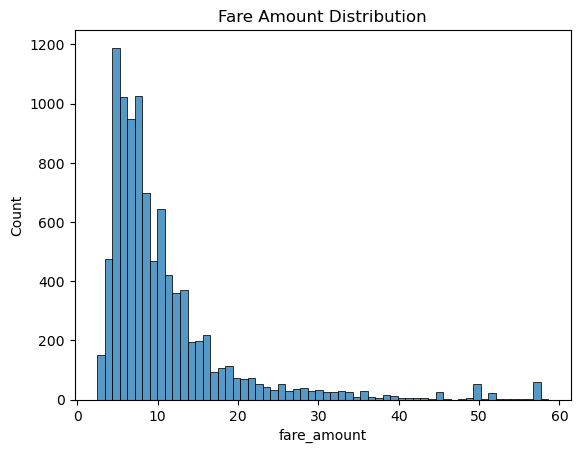

In [213]:
# Plot a histogram of the different fare famounts
sns.histplot(df['fare_amount'], bins=60)
plt.title("Fare Amount Distribution")
plt.show()

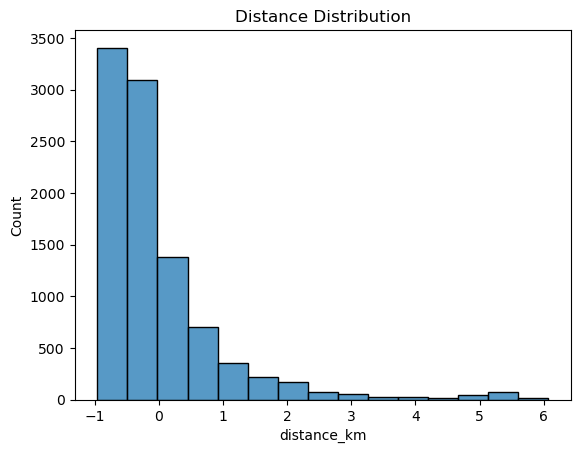

In [214]:
# Plot the histogram of the different distances
sns.histplot(df['distance_km'], bins=15)
plt.title("Distance Distribution")
plt.show()

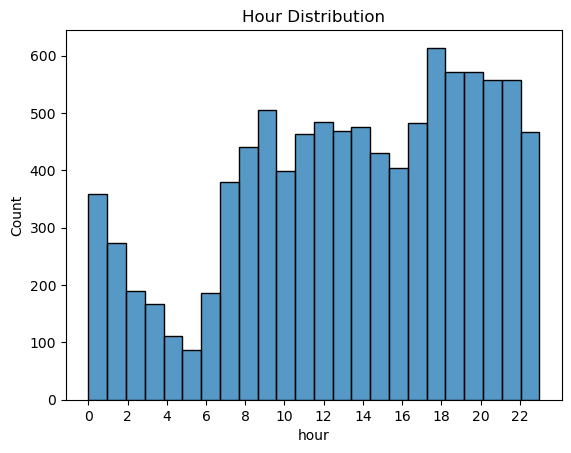

In [215]:
# Plot the histogram of the hours
sns.histplot(df['hour'], bins=24)
plt.xticks(np.arange(0, 24, 2))
plt.title("Hour Distribution")
plt.show()

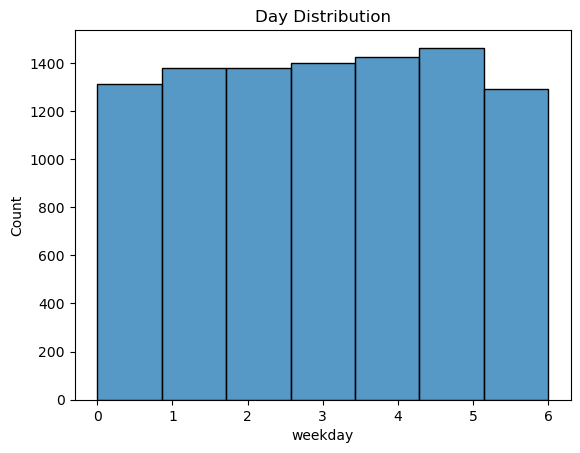

In [216]:
# Plot the histogram of the weekdays
sns.histplot(df['weekday'], bins=7)
plt.title("Day Distribution")
plt.show()

### Bivariate Analysis

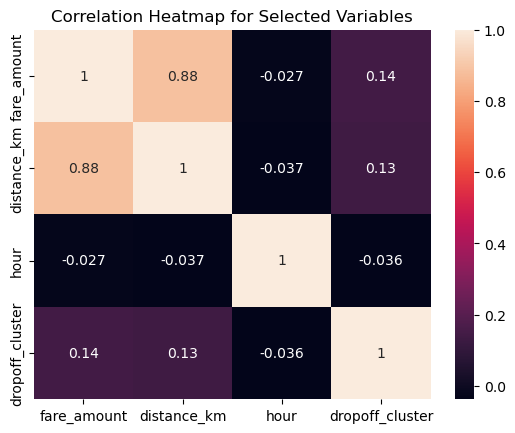

In [217]:
# Plot the correlation matrix for these four features
corr = df[['fare_amount', 'distance_km', 'hour', 'dropoff_cluster']].corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap for Selected Variables")
plt.show()

### Geospatial Analysis

In [218]:
# Invert the scaling so it plots properly on nyc map
df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']] = scaler.inverse_transform(
        df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

In [219]:
# Create GeoDataFrame for pickups and dropoffs
pickup_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['pickup_longitude'], df['pickup_latitude']))
dropoff_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['dropoff_longitude'], df['dropoff_latitude']))

# Load the NYC shapefile
nyc_boundary = gpd.read_file('nyc.shp')

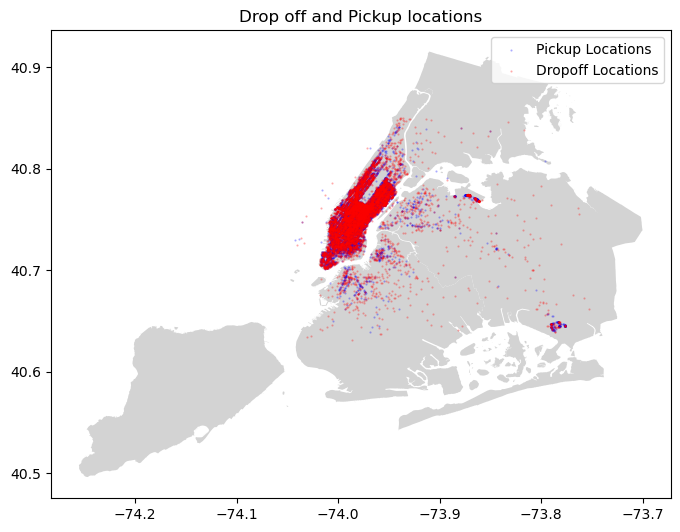

In [220]:
# Plot
fig, ax = plt.subplots(figsize=(8, 8))
nyc_boundary.plot(ax=ax, color='lightgrey')
pickup_gdf.plot(ax=ax, markersize=0.3, color='blue', alpha=0.3, label='Pickup Locations')
dropoff_gdf.plot(ax=ax, markersize=0.3, color='red', alpha=0.3, label='Dropoff Locations')
plt.legend()
plt.title('Drop off and Pickup locations')
plt.show()

<h1> 3. Data Visualization</h1>

### Heatmaps

In [221]:
# Get the coordinates for pickups and dropoffs
pickup_coords = np.array([pickup_gdf.geometry.x, pickup_gdf.geometry.y]).T
dropoff_coords = np.array([dropoff_gdf.geometry.x, dropoff_gdf.geometry.y]).T

C:\Users\manav.000\AppData\Local\Temp\ipykernel_20544\2217790019.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


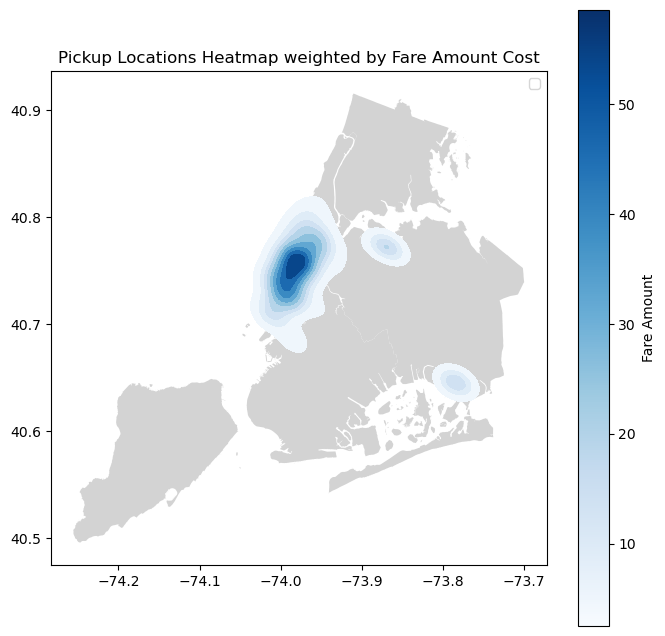

In [222]:
# Plot pickup heatmap, with the weight based on the cost
fig, ax = plt.subplots(figsize=(8, 8))
nyc_boundary.plot(ax=ax, color='lightgrey')
sns.kdeplot(x=pickup_coords[:, 0], y=pickup_coords[:, 1], weights=pickup_gdf['fare_amount'], ax=ax, cmap='Blues', fill=True, alpha=1, label='Pickup Locations')

# Get a color bar to show the cost increase
sm = plt.cm.ScalarMappable(cmap='Blues', norm=mcolors.Normalize(vmin=pickup_gdf['fare_amount'].min(), vmax=pickup_gdf['fare_amount'].max()))
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fare Amount')

plt.legend()
plt.title('Pickup Locations Heatmap weighted by Fare Amount Cost')
plt.show()

C:\Users\manav.000\AppData\Local\Temp\ipykernel_20544\3939793876.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


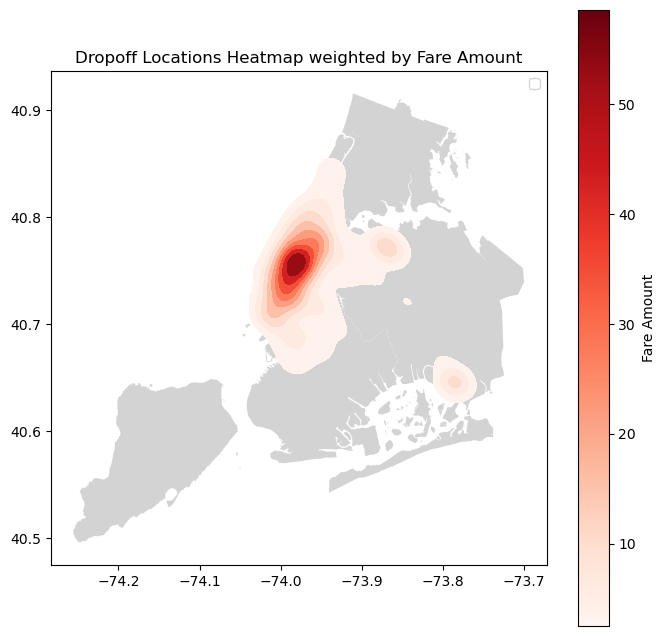

In [223]:
# Plot dropoff heap with weight based on fare cost
fig, ax = plt.subplots(figsize=(8, 8))
nyc_boundary.plot(ax=ax, color='lightgrey')
sns.kdeplot(x=dropoff_coords[:, 0], y=dropoff_coords[:, 1], weights=dropoff_gdf['fare_amount'], ax=ax, cmap='Reds', fill=True, alpha=1, label='Dropoff Locations')

# Get the colorbar for this
sm = plt.cm.ScalarMappable(cmap='Reds', norm=mcolors.Normalize(vmin=dropoff_gdf['fare_amount'].min(), vmax=dropoff_gdf['fare_amount'].max()))
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fare Amount')

plt.legend()
plt.title('Dropoff Locations Heatmap weighted by Fare Amount')
plt.show()

### Fare Distribution by Time of Day

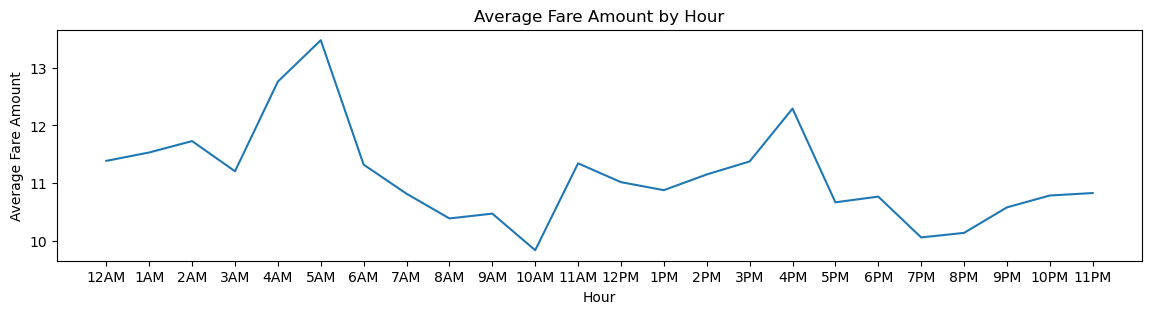

In [224]:
# Group by hour, then get the averages of the fare_amounts for each of the hours
avg_fare = df.groupby('hour')['fare_amount'].mean().reset_index()

# Get labels for 12am to 11pm
hour_labels = [f"{i % 12 or 12}{'AM' if i < 12 else 'PM'}" for i in range(24)]

# Plot this
plt.figure(figsize=(14, 3))
plt.plot(avg_fare['hour'], avg_fare['fare_amount'])
plt.title('Average Fare Amount by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Fare Amount')
plt.xticks(avg_fare['hour'], [hour_labels[i] for i in avg_fare['hour']])
plt.show()

### Distance vs. Fare Scatter Plot

Text(0, 0.5, 'Fare Amount (USD $)')

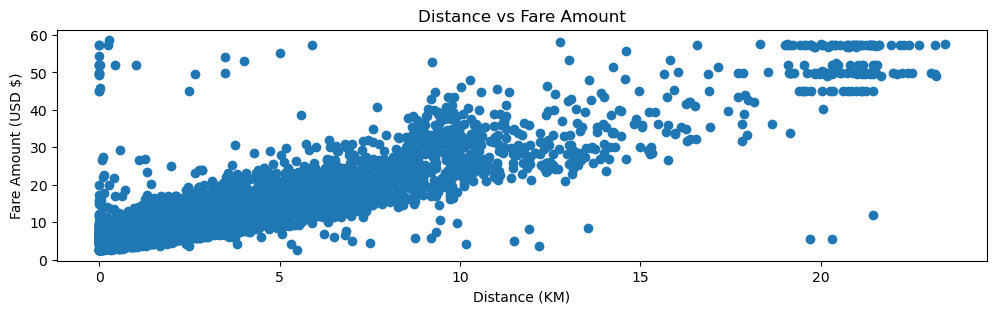

In [225]:
# Plot distance vs fare cost
plt.figure(figsize=(12, 3))
plt.scatter(df['distance_km'], df['fare_amount'])
plt.title('Distance vs Fare Amount')
plt.xlabel('Distance (KM)')
plt.ylabel('Fare Amount (USD $)')

## 4. Model Building: Neural Network Implementation

In [226]:
# Define features and target
features = ['distance_km', 'pickup_cluster', 'dropoff_cluster', 'hour', 'day', 'weekday', 'month', 'is_peak_hour']
X = df[features].values
y = df['fare_amount'].values

# Re-normalize the features
df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']] = scaler.fit_transform(
        df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
print(f"Using device: {device}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

Using device: cpu


In [227]:
class TaxiFarePredictionNN(nn.Module):
    # Create a class to define the model
    def __init__(self):
        super(TaxiFarePredictionNN, self).__init__()
        # Give it linear layers with a relu activation function
        self.fc1 = nn.Linear(len(features), 64)  
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 16)  
        self.fc4 = nn.Linear(16, 1)  
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Give it a forward function for training
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x) 
        return x

model = TaxiFarePredictionNN().to(device)
criterion = nn.L1Loss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. Model Evaluation and Tuning 

In [228]:
epochs = 50
batch_size = 32
patience = 10  
best_val_loss = float('inf')
early_stopping_counter = 0

train_losses = []
val_losses = []

# Loop through each epoch
for epoch in range(epochs):
    # Train the model
    model.train()  
    permutation = torch.randperm(X_train_tensor.size(0)).to(device)
    
    epoch_loss = 0
    # Loop through each batch and get the loss and outputs
    for i in range(0, X_train_tensor.size(0), batch_size):
        optimizer.zero_grad()  

        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / (X_train_tensor.size(0) // batch_size))
    model.eval()  
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()

    val_losses.append(val_loss)

    # Dispplay the loss at each epoch
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Stop the model if we reach a desired accuracy early
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/50, Training Loss: 1114.8586, Validation Loss: 2.3302
Epoch 2/50, Training Loss: 664.0757, Validation Loss: 2.2117
Epoch 3/50, Training Loss: 635.6852, Validation Loss: 2.1851
Epoch 4/50, Training Loss: 625.6926, Validation Loss: 2.1836
Epoch 5/50, Training Loss: 609.7311, Validation Loss: 2.1833
Epoch 6/50, Training Loss: 607.1519, Validation Loss: 2.1802
Epoch 7/50, Training Loss: 607.0349, Validation Loss: 2.2678
Epoch 8/50, Training Loss: 597.3332, Validation Loss: 2.1858
Epoch 9/50, Training Loss: 585.4370, Validation Loss: 2.2521
Epoch 10/50, Training Loss: 579.9408, Validation Loss: 2.1497
Epoch 11/50, Training Loss: 583.1159, Validation Loss: 2.1741
Epoch 12/50, Training Loss: 579.3773, Validation Loss: 2.1503
Epoch 13/50, Training Loss: 576.8718, Validation Loss: 2.1688
Epoch 14/50, Training Loss: 567.1184, Validation Loss: 2.2387
Epoch 15/50, Training Loss: 570.2237, Validation Loss: 2.2421
Epoch 16/50, Training Loss: 559.8175, Validation Loss: 2.1871
Epoch 17/50, Tra

In [229]:
# Save the model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    val_predictions = model(X_val_tensor).cpu().numpy() 

mae = mean_absolute_error(y_val, val_predictions)
print(f"Validation Mean Absolute Error: {mae:.2f}")

Validation Mean Absolute Error: 2.15


C:\Users\manav.000\AppData\Local\Temp\ipykernel_20544\2247704897.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


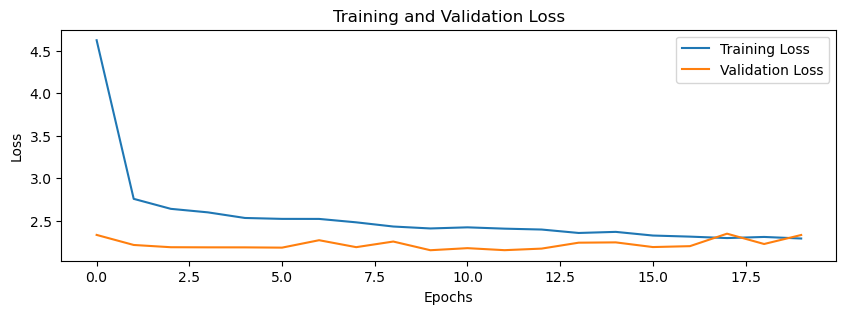

In [230]:
# Display training and validation loss over epochs
plt.figure(figsize=(10, 3))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 6. Analysis and Recommendations 

### Spatial-Temporal Analysis

In [231]:
# Perform a DBSCAN to identify highly dense areas for pickup
db = DBSCAN(eps=0.01, min_samples=50, metric='haversine')
labels = db.fit_predict(np.vstack((pickup_gdf['pickup_latitude'], pickup_gdf['pickup_longitude'])).T)
pickup_gdf['cluster'] = labels

In [232]:
# Perform a DBSCAN to identify highly dense areas for drop-off
labels = db.fit_predict(np.vstack((dropoff_gdf['dropoff_latitude'], dropoff_gdf['dropoff_longitude'])).T)
dropoff_gdf['cluster'] = labels

Text(0.5, 1.0, 'Pickup Clusters')

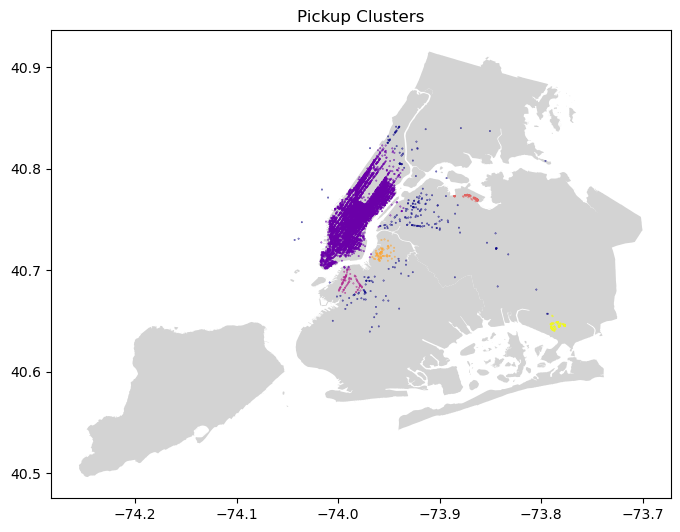

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot pickup clusters with NYC boundary
nyc_boundary.plot(ax=ax, color='lightgrey')
pickup_gdf.plot(column='cluster', ax=ax, cmap='plasma', markersize=0.1)
ax.set_title('Pickup Clusters')

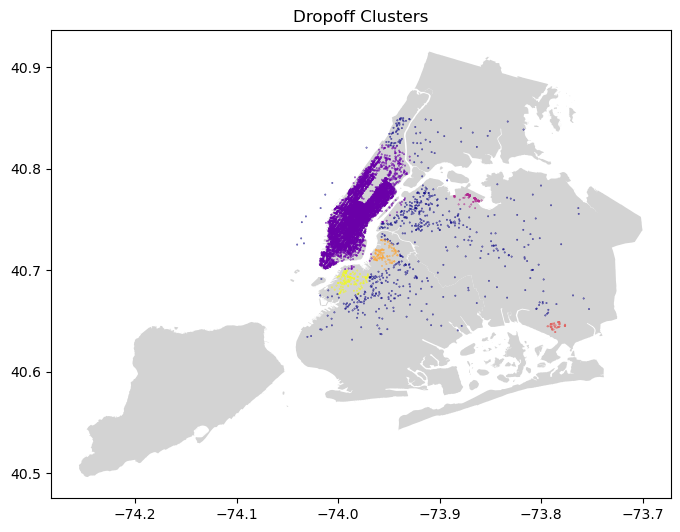

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot dropoff clusters with NYC boundary
nyc_boundary.plot(ax=ax, color='lightgrey')
dropoff_gdf.plot(column='cluster', ax=ax, cmap='plasma', markersize=0.1)
ax.set_title('Dropoff Clusters')
plt.show()

We can see that the barclay's stadium, La Guardia Airport, JFK Airport, and main manhattan are all more dense then other regions

### Peak Demand Analysis

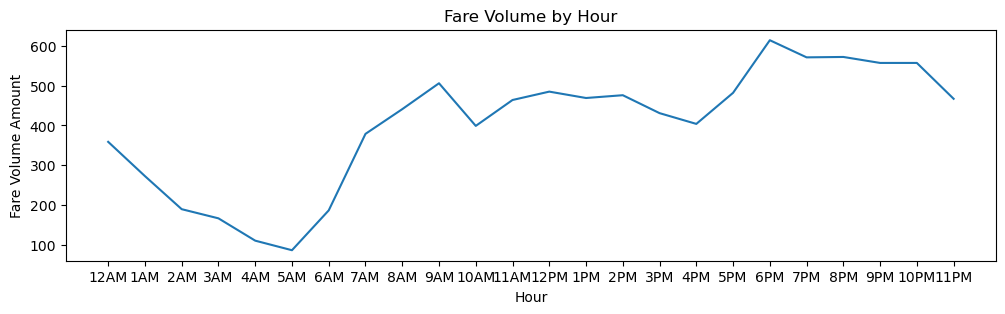

In [235]:
# Group by hour, then get the total amount of the fares for each of the hours
total_fare = df.groupby('hour')['fare_amount'].count().reset_index()

# Get labels for 12am to 11pm
hour_labels = [f"{i % 12 or 12}{'AM' if i < 12 else 'PM'}" for i in range(24)]

# Plot this
plt.figure(figsize=(12, 3))
plt.plot(total_fare['hour'], total_fare['fare_amount'])
plt.title('Fare Volume by Hour')
plt.xlabel('Hour')
plt.ylabel('Fare Volume Amount')
plt.xticks(total_fare['hour'], [hour_labels[i] for i in total_fare['hour']])
plt.show()

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

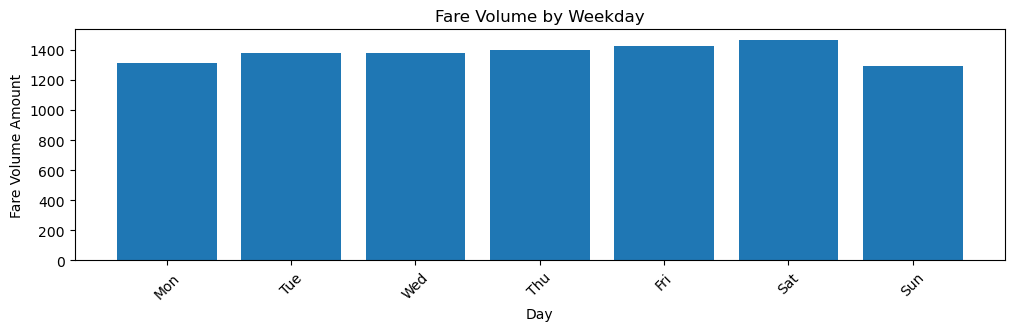

In [236]:
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Group by weekday then get the total amount of the fares for each of the days
total_fare = df.groupby('weekday')['fare_amount'].count().reset_index()

# Re-map the names to the actual names (mon-sun)
total_fare['weekday'] = total_fare['weekday'].map(lambda x: day_names[x])

# Plot this
plt.figure(figsize=(12, 3))
plt.bar(total_fare['weekday'], total_fare['fare_amount'])
plt.title('Fare Volume by Weekday')
plt.xlabel('Day')
plt.ylabel('Fare Volume Amount')
plt.xticks(rotation=45)

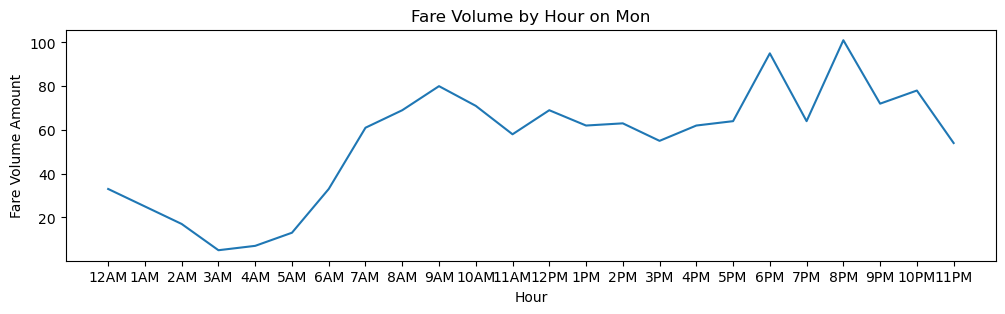

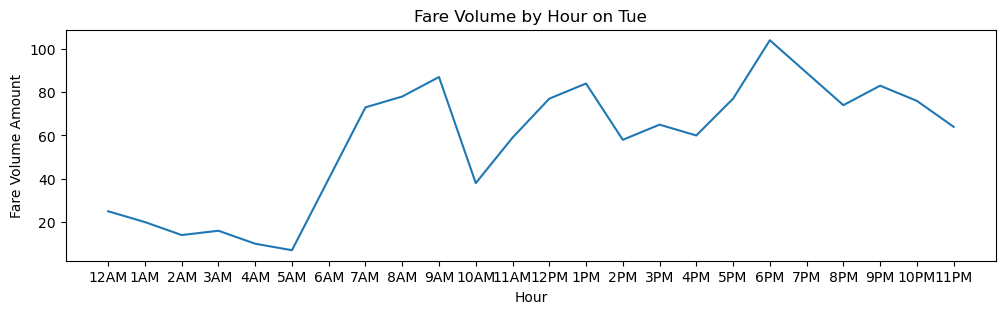

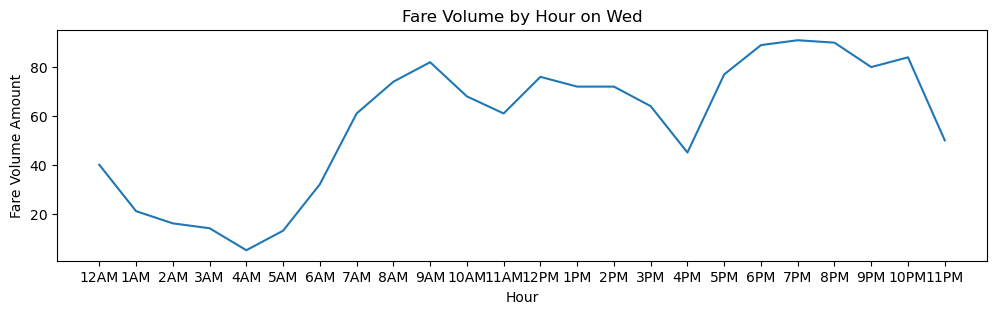

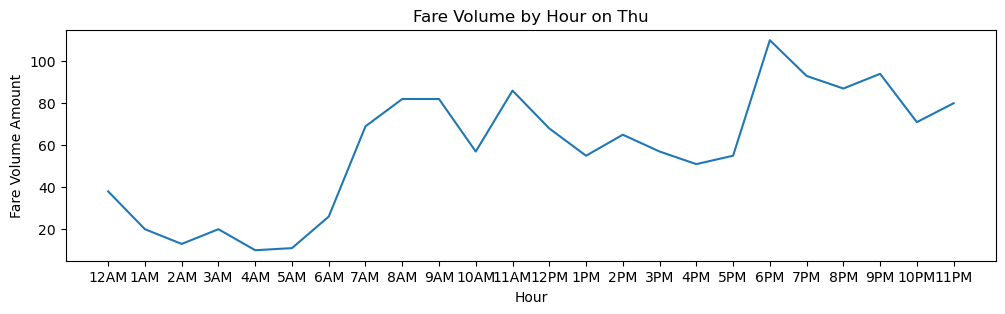

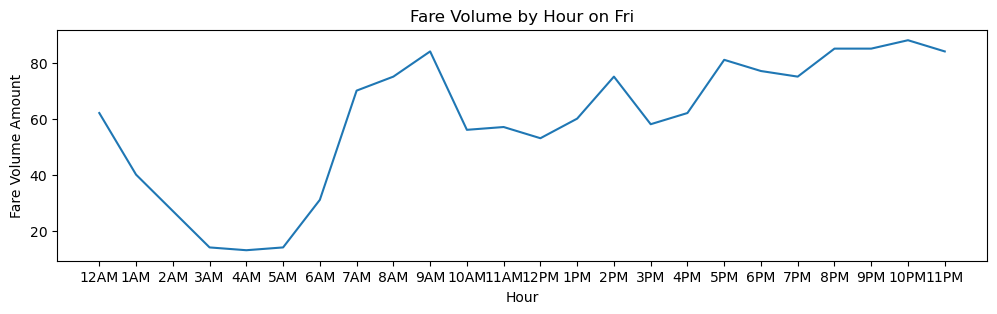

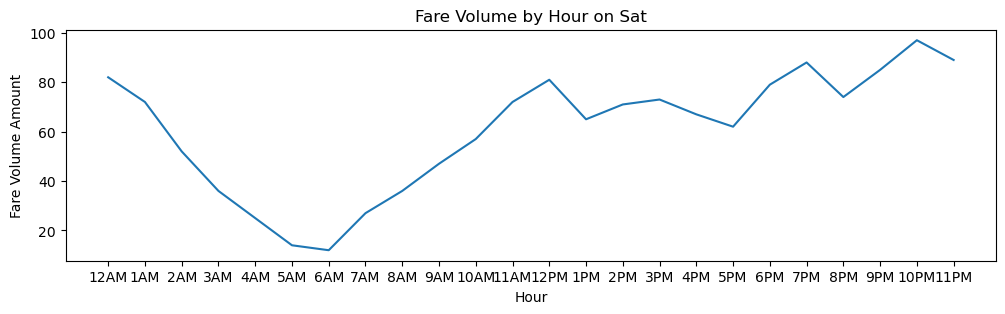

In [ ]:
# Loop through each weekday
for i in range(7):
    # Get a dataframe with only that weekday
    df_weekday = df[df['weekday'] == i]
    
    # Group by hour, then get the total amount of the fares for each of the hours
    total_fare = df_weekday.groupby('hour')['fare_amount'].count().reset_index()
    
    # Get labels for 12am to 11pm
    hour_labels = [f"{i % 12 or 12}{'AM' if i < 12 else 'PM'}" for i in range(24)]
    
    # Plot this
    plt.figure(figsize=(12, 3))
    plt.plot(total_fare['hour'], total_fare['fare_amount'])
    plt.title('Fare Volume by Hour on ' + day_names[i])
    plt.xlabel('Hour')
    plt.ylabel('Fare Volume Amount')
    plt.xticks(total_fare['hour'], [hour_labels[i] for i in total_fare['hour']])
    plt.show()

We can notice that saturday and sunday morning at 12-3am have a lot more fares than other weekdays most likely because people are going out.

In [ ]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Group-by month and get fare-amounts
total_fare = df.groupby('month')['fare_amount'].count().reset_index()

# Map fare-amounts to month names
total_fare['month_name'] = total_fare['month'].map(lambda x: month_names[x - 1])

# Plot the bar chart
plt.figure(figsize=(12, 3))
plt.bar(total_fare['month_name'], total_fare['fare_amount'])
plt.title('Fare Volume by Month')
plt.xlabel('Month')
plt.ylabel('Fare Volume Amount')
plt.xticks(rotation=45)
plt.show()